In [1]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [3]:
def load_labels(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, width, height = map(float, parts)
                boxes.append((x_center, y_center, width, height))
    return boxes


In [4]:
def extract_faces(image_path, label_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    boxes = load_labels(label_path)
    faces = []
    for box in boxes:
        x_center, y_center, bw, bh = box
        x1 = int((x_center - bw / 2) * w)
        y1 = int((y_center - bh / 2) * h)
        x2 = int((x_center + bw / 2) * w)
        y2 = int((y_center + bh / 2) * h)
        face = image[y1:y2, x1:x2]
        if face.size > 0:
            face = cv2.resize(face, (64, 64))
            faces.append(face)
    return faces


In [5]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm
# import os
# import cv2
# import numpy as np
# from glob import glob

# def process_single_image(img_path, label_dir):
#     filename = os.path.splitext(os.path.basename(img_path))[0]
#     label_path = os.path.join(label_dir, filename + '.txt')
#     if not os.path.exists(label_path):
#         return [], []

#     image = cv2.imread(img_path)
#     if image is None:
#         return [], []
#     h, w = image.shape[:2]

#     # Конвертація в RGB один раз
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     try:
#         with open(label_path, 'r') as f:
#             boxes = []
#             for line in f.readlines():
#                 parts = line.strip().split()
#                 if len(parts) == 5:
#                     _, x_center, y_center, bw, bh = map(float, parts)
#                     boxes.append((x_center, y_center, bw, bh))
#     except Exception:
#         return [], []

#     X_local = []
#     for box in boxes:
#         x_center, y_center, bw, bh = box
#         x1 = int((x_center - bw / 2) * w)
#         y1 = int((y_center - bh / 2) * h)
#         x2 = int((x_center + bw / 2) * w)
#         y2 = int((y_center + bh / 2) * h)
#         face = image_rgb[y1:y2, x1:x2]
#         if face.size == 0:
#             continue
#         face = cv2.resize(face, (64, 64))
#         X_local.append(face.flatten())

#     y_local = [0] * len(X_local)
#     return X_local, y_local

# def prepare_dataset(image_dir, label_dir, max_workers=4, max_images=None):
#     image_paths = glob(os.path.join(image_dir, '*.jpg'))

#     if max_images:
#         image_paths = image_paths[:max_images]

#     X, y = [], []
#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         futures = [executor.submit(process_single_image, path, label_dir) for path in image_paths]
#         for future in tqdm(as_completed(futures), total=len(futures), desc=f'Processing {image_dir}'):
#             x_part, y_part = future.result()
#             X.extend(x_part)
#             y.extend(y_part)

#     return np.array(X), np.array(y)



import random

def generate_negative_boxes(pos_boxes, img_w, img_h, n_negatives=2):
    neg_boxes = []
    tries = 0
    max_tries = n_negatives * 10

    while len(neg_boxes) < n_negatives and tries < max_tries:
        box_w = random.randint(30, 80)
        box_h = random.randint(30, 80)
        x1 = random.randint(0, img_w - box_w)
        y1 = random.randint(0, img_h - box_h)
        x2, y2 = x1 + box_w, y1 + box_h
        iou_ok = True
        for (px1, py1, px2, py2) in pos_boxes:
            if not (x2 < px1 or x1 > px2 or y2 < py1 or y1 > py2):
                iou_ok = False
                break
        if iou_ok:
            neg_boxes.append((x1, y1, x2, y2))
        tries += 1
    return neg_boxes

def extract_pos_boxes(label_path, img_w, img_h):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, bw, bh = map(float, parts)
                x1 = int((x_center - bw / 2) * img_w)
                y1 = int((y_center - bh / 2) * img_h)
                x2 = int((x_center + bw / 2) * img_w)
                y2 = int((y_center + bh / 2) * img_h)
                boxes.append((x1, y1, x2, y2))
    return boxes

def prepare_dataset_with_negatives(image_dir, label_dir, max_workers=4, max_images=None):
    image_paths = glob(os.path.join(image_dir, '*.jpg'))
    if max_images:
        image_paths = image_paths[:max_images]

    X, y = [], []

    def process_image(path):
        filename = os.path.splitext(os.path.basename(path))[0]
        label_path = os.path.join(label_dir, filename + '.txt')
        image = cv2.imread(path)
        if image is None or not os.path.exists(label_path):
            return [], []
        img_h, img_w = image.shape[:2]
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Позитиви
        pos_boxes = extract_pos_boxes(label_path, img_w, img_h)
        X_local = []
        for (x1, y1, x2, y2) in pos_boxes:
            face = image_rgb[y1:y2, x1:x2]
            if face.size == 0:
                continue
            face = cv2.resize(face, (64, 64))
            X_local.append((face.flatten(), 0))  # label 0

        # Негативи
        neg_boxes = generate_negative_boxes(pos_boxes, img_w, img_h)
        for (x1, y1, x2, y2) in neg_boxes:
            patch = image_rgb[y1:y2, x1:x2]
            if patch.size == 0:
                continue
            patch = cv2.resize(patch, (64, 64))
            X_local.append((patch.flatten(), 1))  # label 1

        return zip(*X_local)

    from concurrent.futures import ThreadPoolExecutor, as_completed
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_image, path) for path in image_paths]
        for future in tqdm(as_completed(futures), total=len(futures), desc=f'Preparing with negatives'):
            result = future.result()
            if result:
                x_part, y_part = result
                X.extend(x_part)
                y.extend(y_part)

    return np.array(X), np.array(y)


In [6]:
# import os

# num_workers = os.cpu_count()
# print(f"Available logical CPUs: {num_workers}")


In [7]:
# X_train, y_train = prepare_dataset('drive/MyDrive/FaceTrackAI/data/images/train', 'drive/MyDrive/FaceTrackAI/data/labels/train', max_workers=2, max_images=5000)
# X_val, y_val = prepare_dataset('drive/MyDrive/FaceTrackAI/data/images/val', 'drive/MyDrive/FaceTrackAI/data/labels/val', max_workers=2, max_images=1500)

X_train, y_train = prepare_dataset_with_negatives('drive/MyDrive/FaceTrackAI/data/images/train', 'drive/MyDrive/FaceTrackAI/data/labels/train', max_workers=2, max_images=5000)
X_val, y_val = prepare_dataset_with_negatives('drive/MyDrive/FaceTrackAI/data/images/val', 'drive/MyDrive/FaceTrackAI/data/labels/val', max_workers=2, max_images=1500)

Preparing with negatives: 100%|██████████| 1500/1500 [01:36<00:00, 15.46it/s]


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [9]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [10]:
scaler_loaded = joblib.load('scaler.joblib')

# SVM

## Training

In [ ]:
from sklearn.svm import LinearSVC

print("Training LinearSVC...")
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train_scaled, y_train)
svm_preds = svm_model.predict(X_val_scaled)


Training LinearSVC...


## Results

In [ ]:
print("SVM Classification Report:")
print(classification_report(y_val, svm_preds))
print("SVM Accuracy:", accuracy_score(y_val, svm_preds))

## Saving Model

In [ ]:
joblib.dump(svm_model, 'svm_model.joblib')

## Downloading Model

In [ ]:
svm_preds = svm_model_loaded.predict(X_val_scaled)
print("Accuracy after loading:", accuracy_score(y_val, svm_preds))

# Random Forest

## Training

In [13]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_val_scaled)

Training Random Forest...


## Results

In [14]:
print("Random Forest Classification Report:")
print(classification_report(y_val, rf_preds))
print("Random Forest Accuracy:", accuracy_score(y_val, rf_preds))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4806

    accuracy                           1.00      4806
   macro avg       1.00      1.00      1.00      4806
weighted avg       1.00      1.00      1.00      4806

Random Forest Accuracy: 1.0


## Saving Model

In [15]:
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

## Downloading the Model

In [17]:
rf_model_loaded = joblib.load('rf_model.joblib')

rf_preds_loaded = rf_model_loaded.predict(X_val_scaled)
print("Accuracy (loaded model):", accuracy_score(y_val, rf_preds_loaded))

Accuracy (loaded model): 1.0


# KNN

## Training

In [19]:
print("Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)
knn_preds = knn_model.predict(X_val_scaled)

Training KNN...


## Results

In [20]:
print("KNN Classification Report:")
print(classification_report(y_val, knn_preds))
print("KNN Accuracy:", accuracy_score(y_val, knn_preds))

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4806

    accuracy                           1.00      4806
   macro avg       1.00      1.00      1.00      4806
weighted avg       1.00      1.00      1.00      4806

KNN Accuracy: 1.0


## Saving Model

In [21]:
joblib.dump(knn_model, 'knn_model.joblib')

['knn_model.joblib']

## Downloading Model

In [27]:
def classify_and_draw(image_path, label_path, models, model_names, scaler):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Завантажити анотації
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, bw, bh = map(float, parts)
                x1 = int((x_center - bw / 2) * w)
                y1 = int((y_center - bh / 2) * h)
                x2 = int((x_center + bw / 2) * w)
                y2 = int((y_center + bh / 2) * h)
                boxes.append((x1, y1, x2, y2))

    # Відображення результатів для кожної моделі
    fig, axs = plt.subplots(1, len(models), figsize=(6 * len(models), 6))
    if len(models) == 1:
        axs = [axs]

    for ax, model, name in zip(axs, models, model_names):
        img_copy = image_rgb.copy()

        for (x1, y1, x2, y2) in boxes:
            face = image_rgb[y1:y2, x1:x2]
            if face.size == 0:
                continue
            face_resized = cv2.resize(face, (64, 64)).flatten().reshape(1, -1)
            face_scaled = scaler.transform(face_resized)

            pred = model.predict(face_scaled)[0]
            label = "Face" if pred == 0 else "Not face"
            color = (0, 255, 0) if pred == 0 else (255, 0, 0)

            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_copy, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        ax.set_title(name)
        ax.imshow(img_copy)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [28]:
# import os

# folder_path = 'drive/MyDrive/FaceTrackAI/data/images/train/'
# files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
# print(files)


['eced18f2a198710c.jpg', 'eb8931c03bc56058.jpg', 'ec63a44741bb00f1.jpg', 'ec6647280c786199.jpg', 'eb6b76877b59d65c.jpg', 'ec4ffd40e25b25d7.jpg', 'ec290d04bb119947.jpg', 'eb6940e68a686de7.jpg', 'ec8a7fb6e8536410.jpg', 'ed43b0a3ce24081c.jpg', 'ec3bdf07537c7991.jpg', 'eb39cd58fc4e30c6.jpg', 'ec52738edca1c616.jpg', 'ed185570c092cfc6.jpg', 'ed09e528dd26e90d.jpg', 'ec760189bff29c53.jpg', 'eb8b8beda23303d1.jpg', 'ebc22d6bcf092a84.jpg', 'eca440a58acdfa8e.jpg', 'ebd10cd0454ffe43.jpg', 'ebf7c44b25c6dd2a.jpg', 'eb7dbdc44e8493da.jpg', 'ec13b12e7193b4fd.jpg', 'eb6a27ae2478c47d.jpg', 'ecec0cd4c244bb4a.jpg', 'ed249b3099ef6f7f.jpg', 'ec84520109400166.jpg', 'ec1d7f2b02ce6efe.jpg', 'ec9e54a55484f244.jpg', 'ec3b13a7904f8d73.jpg', 'ecb058e00c469093.jpg', 'eb27d2c5ba28f719.jpg', 'ec28e8c711b6f20e.jpg', 'eccfeaebe000f6eb.jpg', 'eb2618c6274a9560.jpg', 'ecfd54a4f16ebf98.jpg', 'eb40e57f43e0d0f2.jpg', 'ece4c2257c1c7d51.jpg', 'ec771c013f53c4e6.jpg', 'ec1128e4c6190f4a.jpg', 'ec7b283313f4e066.jpg', 'ed2b98878050e2

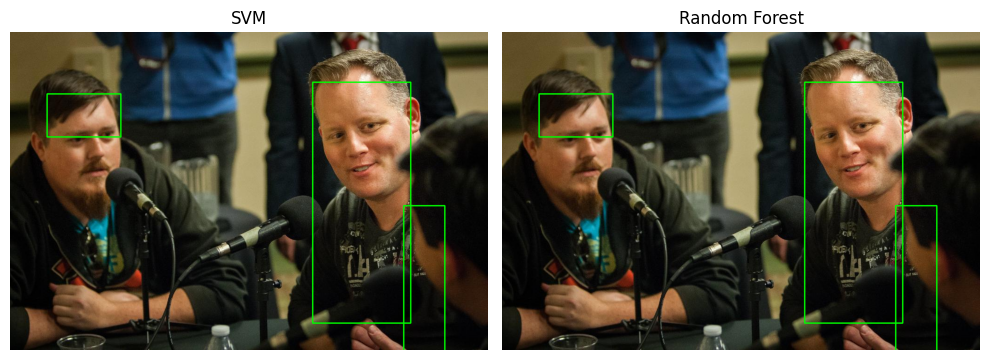

In [33]:
# Приклад використання:
models = [ rf_model, knn_model]
model_names = ['SVM', 'Random Forest', 'KNN']

test_image = 'drive/MyDrive/FaceTrackAI/data/images/train/eb6b76877b59d65c.jpg'
test_label = 'drive/MyDrive/FaceTrackAI/data/labels/train/eb6b76877b59d65c.txt'

classify_and_draw(test_image, test_label, models, model_names, scaler)
